In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import warnings
warnings.filterwarnings("ignore")

CELL_LINES = [
    'Sst-IRES-Cre', 
    'Pvalb-IRES-Cre', 
    'Tlx3-Cre_PL56', 
    'Sim1-Cre_KJ18'
]

In [2]:
ctc = CellTypesCache()
features = ctc.get_ephys_features()
features[0]

{'adaptation': nan,
 'avg_isi': 134.7,
 'electrode_0_pa': 22.6974983946748,
 'f_i_curve_slope': 0.0833545918367347,
 'fast_trough_t_long_square': 1.18768,
 'fast_trough_t_ramp': 13.2952,
 'fast_trough_t_short_square': 1.025916,
 'fast_trough_v_long_square': -56.3750038146973,
 'fast_trough_v_ramp': -57.3854204813639,
 'fast_trough_v_short_square': -57.4312507629395,
 'has_burst': False,
 'has_delay': False,
 'has_pause': False,
 'id': 529951870,
 'input_resistance_mohm': 54.894264,
 'latency': 0.0745600000000002,
 'peak_t_long_square': 1.18506,
 'peak_t_ramp': 13.2928933333333,
 'peak_t_short_square': 1.023716,
 'peak_v_long_square': 47.8750038146973,
 'peak_v_ramp': 47.4375025431315,
 'peak_v_short_square': 48.0750022888184,
 'rheobase_sweep_id': 529881372,
 'rheobase_sweep_number': 78,
 'ri': 60.7811734080315,
 'sag': 0.116451561450958,
 'seal_gohm': 1.488282368,
 'slow_trough_t_long_square': nan,
 'slow_trough_t_ramp': nan,
 'slow_trough_t_short_square': nan,
 'slow_trough_v_long_sq

In [3]:
def get_filtered_cell_ids():
    cell_api = CellTypesApi()
    
    # Get all cell IDs
    ids = cell_api.list_cells_api(
        reporter_status=None
    )
    
    # Filter for Layer 5 visual cortex cells
    filter_cell_id = {}
    for cell in ids:
        if (cell['donor__species'] != 'Homo Sapiens' and 
            cell['structure__acronym'] == 'VISp5' and 
            cell['line_name'] in CELL_LINES):
            
            if cell['line_name'] in ['Pvalb-IRES-Cre', 'Sst-IRES-Cre']:
                # Check if dendrite type is aspiny
                if cell['tag__dendrite_type'] == 'aspiny':
                    if cell['line_name'] not in filter_cell_id:
                        filter_cell_id[cell['line_name']] = []
                    filter_cell_id[cell['line_name']].append(cell['specimen__id'])
            
            # For Sim1 and Tlx3 lines, check if spiny
            elif cell['line_name'] in ['Sim1-Cre_KJ18', 'Tlx3-Cre_PL56']:
                if cell['tag__dendrite_type'] == 'spiny':
                    if cell['line_name'] not in filter_cell_id:
                        filter_cell_id[cell['line_name']] = []
                    filter_cell_id[cell['line_name']].append(cell['specimen__id'])
    
    return filter_cell_id

In [4]:
def extract_cell_features(cell_ids_by_line):
    ctc = CellTypesCache()
    features = ctc.get_ephys_features()

    # Organize features by cell line
    matched_features = {}
    for line, cell_ids in cell_ids_by_line.items():
        line_features = []
        for cell_features in features:
            if cell_features['specimen_id'] in cell_ids:
                line_features.append({
                    'line': line,
                    'cell_id': cell_features.get('id'),
                    'input_resistance': cell_features.get('input_resistance_mohm'),
                    'membrane_time_constant': cell_features.get('tau'),
                    'fi_curve_slope': cell_features.get('f_i_curve_slope'),
                    'vrest': cell_features.get("vrest")
                })
        matched_features[line] = line_features
    
    return matched_features


In [5]:
def create_feature_dataframe(matched_features):
    # Combine features from all lines into a single DataFrame
    all_features = []
    for line, features in matched_features.items():
        for feature in features:
            all_features.append(feature)
    
    return pd.DataFrame(all_features)


In [6]:
color_dict = {
    'SST': 'skyblue',
    'PV': 'lightgreen',
    'IT': 'salmon',
    'ET': 'gold'
}

def plot_features(df):
    # Define features to plot
    features = [
        'input_resistance',
        'membrane_time_constant',
        'fi_curve_slope',
        'vrest'
    ]

    # Create a figure with subplots for each feature
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()


    for i, feature in enumerate(features):
        # Create a box plot with overlay of swarm plot
        sns.boxplot(x='line', y=feature, data=df, ax=axes[i], palette=color_dict)
        
        # Swarm plot for the dataframe data
        sns.swarmplot(x='line', y=feature, data=df, color='.25', ax=axes[i], size=4,label='Experiment Data')
        
        axes[i].set_title(f'{feature.replace("_", " ").title()} by Cell Line')
        axes[i].set_xlabel('Cell Line')
        axes[i].set_ylabel(feature.replace('_', ' ').title())
        axes[i].tick_params(axis='x', rotation=45)
        
        #Add legend
        handles, labels = axes[i].get_legend_handles_labels()
        #Remove duplicate labels while preserving order
        seen = set()
        handles_labels = [(h, l) for h, l in zip(handles, labels) 
                       if not (l in seen or seen.add(l))]
        handles, labels = zip(*handles_labels)
        
        axes[i].legend(handles, labels, loc='best')

    plt.tight_layout()
    plt.show()

In [7]:
# Get filtered cell IDs by line
cell_ids_by_line = get_filtered_cell_ids()

# Extract features
matched_features = extract_cell_features(cell_ids_by_line)

# Create DataFrame
df = create_feature_dataframe(matched_features)

# rename cell lines with the names we like
df['line'] = df['line'].replace('Sst-IRES-Cre', 'SST')
df['line'] = df['line'].replace('Pvalb-IRES-Cre', 'PV')
df['line'] = df['line'].replace('Tlx3-Cre_PL56', 'IT')
df['line'] = df['line'].replace('Sim1-Cre_KJ18', 'ET')


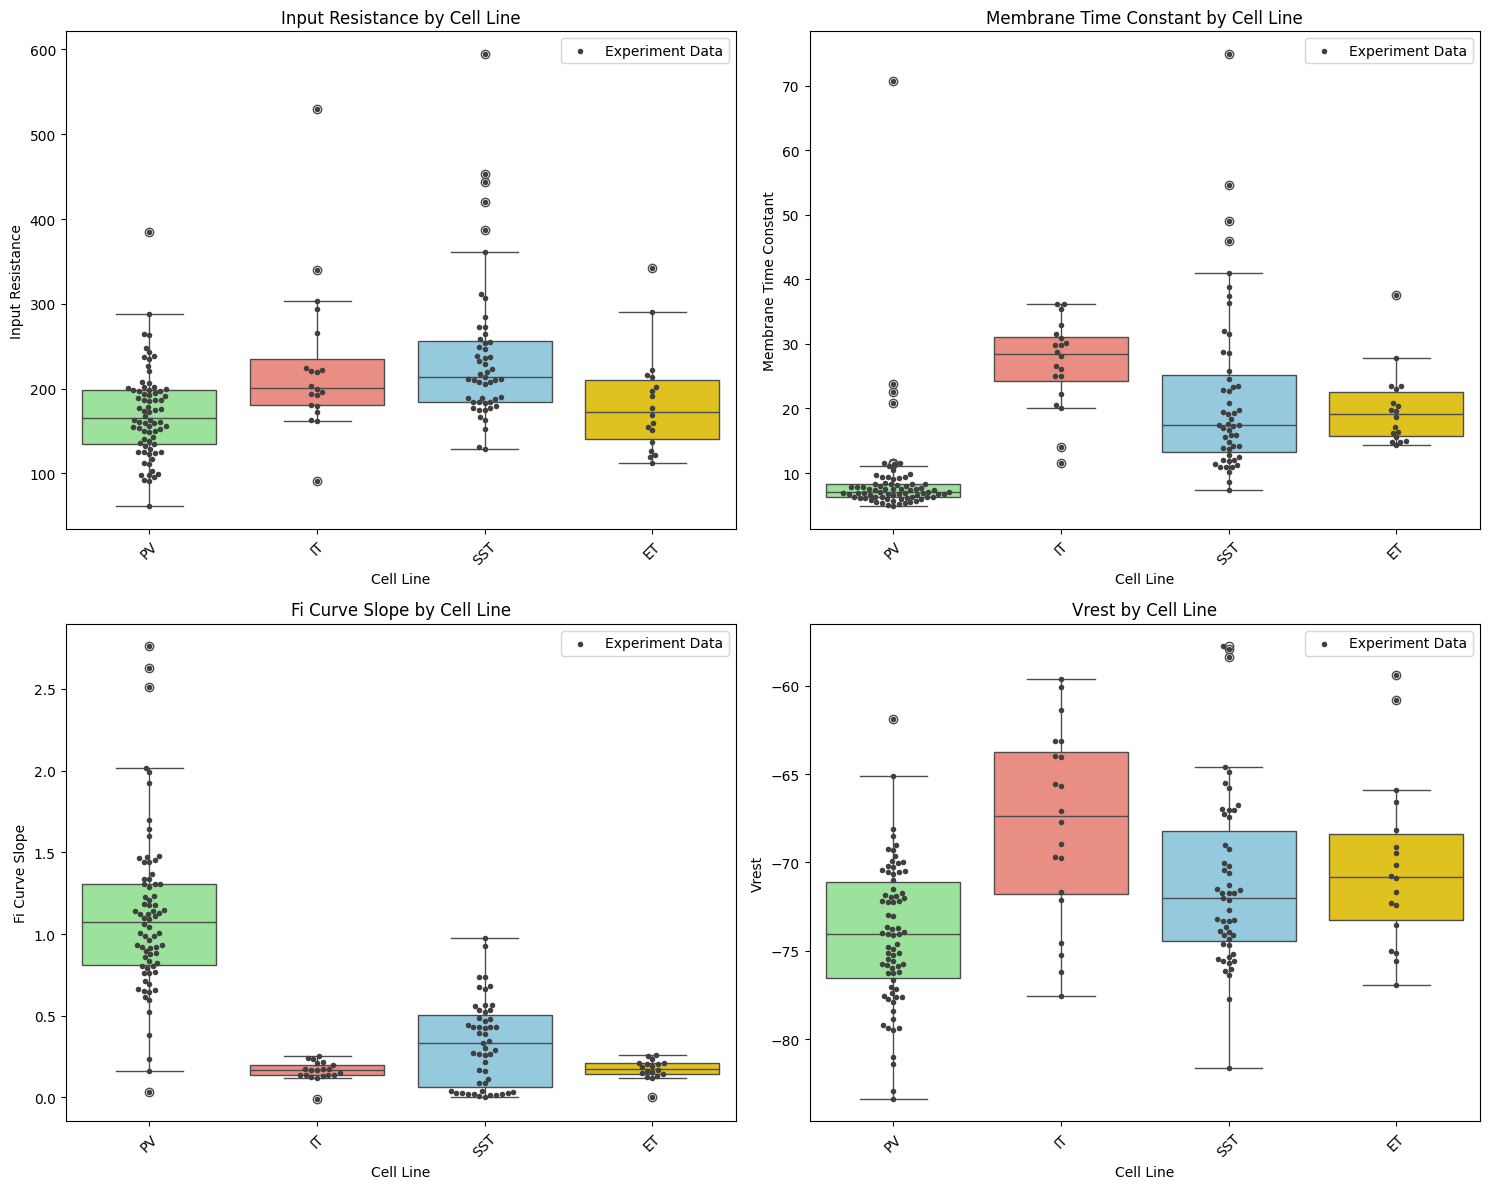

Pvalb-IRES-Cre: 74 cells
Tlx3-Cre_PL56: 20 cells
Sst-IRES-Cre: 51 cells
Sim1-Cre_KJ18: 18 cells


In [8]:
# Plot features
plot_features(df)

# Print summary
for line, features in matched_features.items():
    print(f"{line}: {len(features)} cells")
    

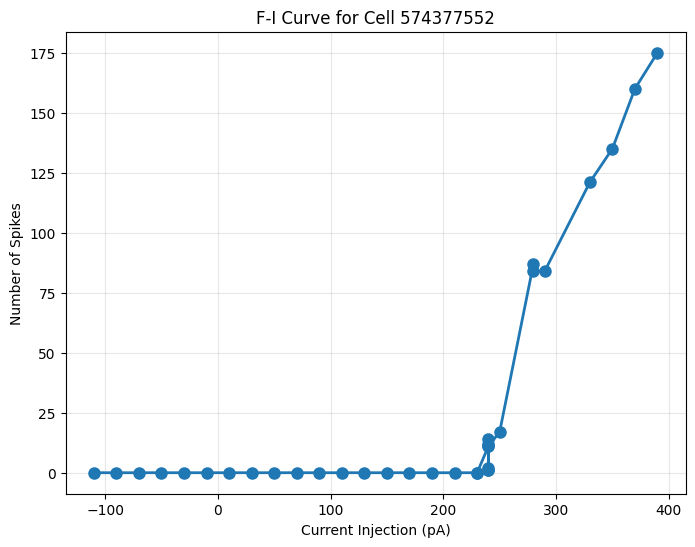

FI slope: 1.161 spikes/pA
Rheobase: 240.0 pA


In [9]:
from scipy.stats import sem

def find_slope(X, Y):
    """Finds the slope and intercept using least squares
    
    """
    # Create the A matrix with a column of X and a column of ones (for the intercept term)
    A = np.vstack([X, np.ones_like(X)]).T

    # Perform least-squares fitting to find the slope (m) and intercept (c)
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Return the slope (m) and intercept (c)
    return m, c

def fit_slope_to_max_y(X, Y):
    """Fits a line between Y > 0 and the point where Y reaches its maximum"""
    # Find where Y > 0
    positive_data = Y > 0
    X_positive = X[positive_data]
    Y_positive = Y[positive_data]

    # Find the index of the maximum Y value
    max_idx = np.argmax(Y_positive)

    # Only use data from where Y is increasing up to the max value
    X_fit = X_positive[:max_idx + 1]
    Y_fit = Y_positive[:max_idx + 1]

    # Find the slope and intercept for this range
    m, c = find_slope(X_fit, Y_fit)

    return m, c, X_fit, Y_fit

def find_rheobase(X,Y):
    """Rheobase is min current to cause a spike"""
    non_zero_indices = np.nonzero(Y)[0]
    if len(non_zero_indices) > 0:
        rheobase = X[non_zero_indices[0]]
        return rheobase
    else:
        return None

def get_cell_fi_data(cell_id):
    """Get FI curve data for a single cell"""
    sweeps = ctc.get_ephys_sweeps(cell_id)
    current_clamp_sweeps = [s for s in sweeps if 'Long Square' in s['stimulus_name']]
    if not current_clamp_sweeps:
        return None
    currents = np.array([s['stimulus_absolute_amplitude'] for s in current_clamp_sweeps])
    spike_counts = np.array([s['num_spikes'] if s['num_spikes'] is not None else 0 for s in current_clamp_sweeps])
    # Sort by current amplitude
    idx = np.argsort(currents)
    currents = currents[idx]
    spike_counts = spike_counts[idx]
    
    # Compute slope and rheobase
    slope = None
    rheobase = None
    if len(spike_counts) > 1 and np.any(spike_counts > 0):
        slope, _, _, _ = fit_slope_to_max_y(currents, spike_counts)
        rheobase = find_rheobase(currents, spike_counts)
    
    return {'currents': currents, 'spike_counts': spike_counts, 'slope': slope, 'rheobase': rheobase}

def plot_single_fi_curve(cell_id):
    """Plot FI curve for a single cell"""
    data = get_cell_fi_data(cell_id)
    if data is None:
        print(f"No FI data available for cell {cell_id}")
        return
    
    plt.figure(figsize=(8, 6))
    plt.plot(data['currents'], data['spike_counts'], 'o-', markersize=8, linewidth=2)
    plt.xlabel('Current Injection (pA)')
    plt.ylabel('Number of Spikes')
    plt.title(f'F-I Curve for Cell {cell_id}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    if data['slope'] is not None:
        print(f"FI slope: {data['slope']:.3f} spikes/pA")
    if data['rheobase'] is not None:
        print(f"Rheobase: {data['rheobase']:.1f} pA")

def plot_population_fi_curve(pop):
    """Plot FI curves for a population of cells"""
    cell_ids = cell_ids_by_line[pop]
    
    all_currents = []
    all_spike_counts = []
    all_slopes = []
    all_rheobases = []
    
    for cell_id in cell_ids:
        data = get_cell_fi_data(cell_id)
        if data is None:
            continue
        all_currents.append(data['currents'])
        all_spike_counts.append(data['spike_counts'])
        if data['slope'] is not None:
            all_slopes.append(data['slope'])
        if data['rheobase'] is not None:
            all_rheobases.append(data['rheobase'])
    
    if not all_currents:
        print(f"No FI data available for population {pop}")
        return
    
    # Find common current steps
    common_currents = np.unique(np.concatenate(all_currents))
    # Interpolate spike counts to common currents
    spike_matrix = np.zeros((len(all_spike_counts), len(common_currents)))
    for i, (currents, spikes) in enumerate(zip(all_currents, all_spike_counts)):
        spike_matrix[i] = np.interp(common_currents, currents, spikes)
    
    mean_spikes = np.mean(spike_matrix, axis=0)
    ci = sem(spike_matrix, axis=0) * 1.96  # 95% CI
    
    plt.figure(figsize=(10, 7))
    # Plot individual curves
    for spikes in spike_matrix:
        plt.plot(common_currents, spikes, color='gray', alpha=0.3)
    # Plot mean curve
    plt.plot(common_currents, mean_spikes, 'o-', color='blue', label='Mean FI curve', linewidth=2)
    # Plot confidence interval
    plt.fill_between(common_currents, mean_spikes - ci, mean_spikes + ci, color='blue', alpha=0.2, label='95% CI')
    plt.xlabel('Current Injection (pA)')
    plt.ylabel('Number of Spikes')
    plt.title(f'FI Curves for {pop} (n={len(all_spike_counts)})')
    plt.grid(True, alpha=0.3)
    plt.legend()    
    plt.show()
    
    # Print summary
    if all_slopes:
        print(f"Mean FI slope: {np.mean(all_slopes):.3f} spikes/pA")
    if all_rheobases:
        print(f"Mean rheobase: {np.mean(all_rheobases):.1f} pA")

#cell_id = cell_ids_by_line['Pvalb-IRES-Cre'][0]
cell_id = 574377552

plot_single_fi_curve(cell_id)

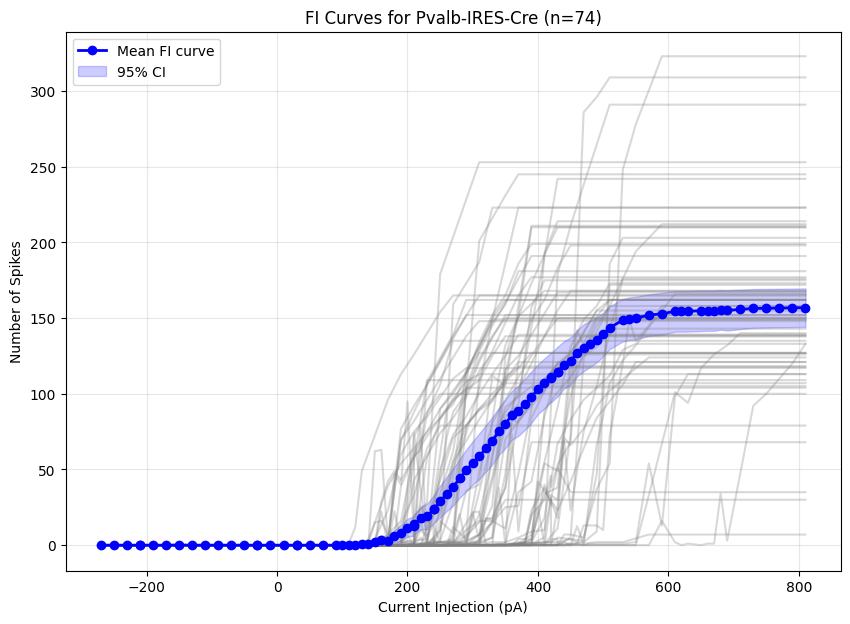

Mean FI slope: 1.102 spikes/pA
Mean rheobase: 269.9 pA


In [10]:
plot_population_fi_curve('Pvalb-IRES-Cre')

2025-09-23 10:59:02,088 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/659447296


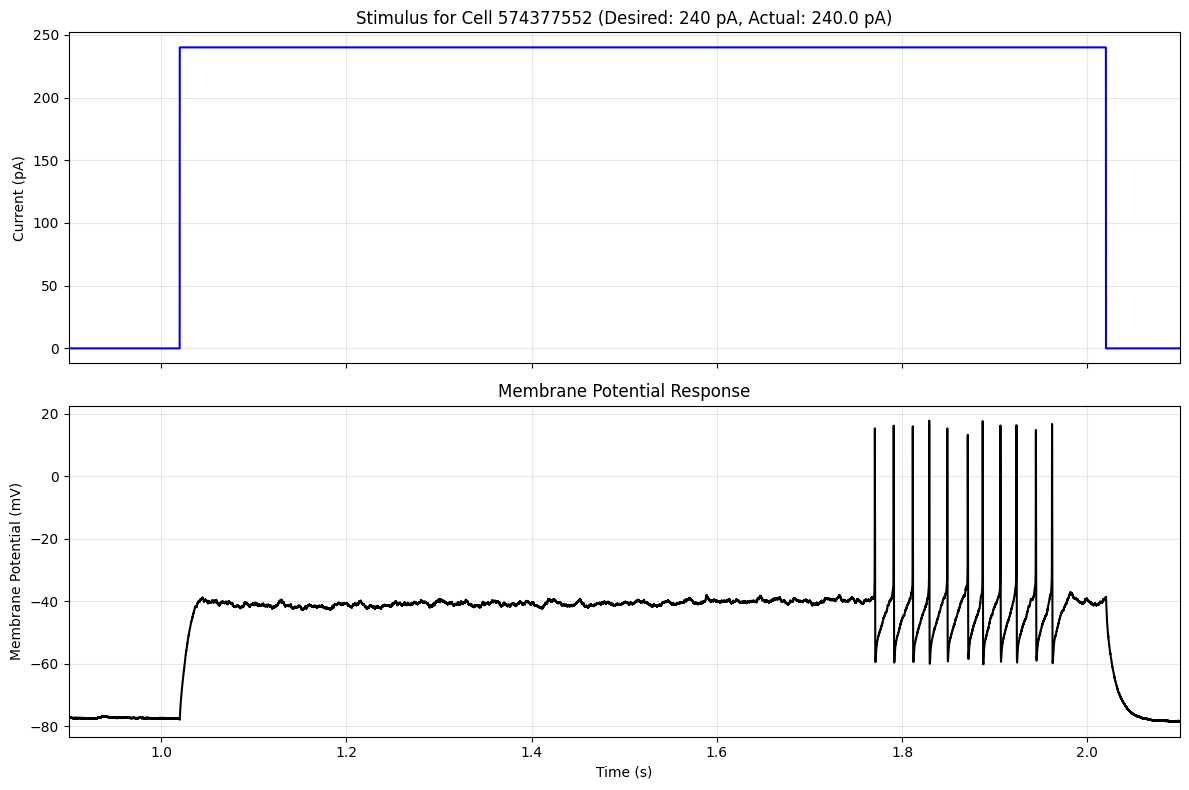

Cell ID: 574377552
Desired current: 240 pA
Actual current: 240.0 pA
Number of spikes: 11


In [11]:
# Functions for getting and plotting current clamp responses

def get_cell_response_data(cell_id, desired_current):
    """Get response data for a cell at the closest current to desired_current"""
    sweeps = ctc.get_ephys_sweeps(cell_id)
    current_clamp_sweeps = [s for s in sweeps if 'Long Square' in s['stimulus_name']]
    
    if not current_clamp_sweeps:
        return None
    
    # Find the sweep with current closest to desired_current
    selected_sweep = min(current_clamp_sweeps, key=lambda s: abs(s['stimulus_absolute_amplitude'] - desired_current))
    
    sweep_number = selected_sweep['sweep_number']
    current_amplitude = selected_sweep['stimulus_absolute_amplitude']
    num_spikes = selected_sweep['num_spikes']
    
    # Download the data
    data_set = ctc.get_ephys_data(cell_id)
    sweep_data = data_set.get_sweep(sweep_number)
    
    # Extract time, voltage, and stimulus
    sampling_rate = sweep_data['sampling_rate']
    time = np.arange(0, len(sweep_data['response'])) / sampling_rate
    voltage = sweep_data['response'] * 1000  # Convert to mV
    stimulus = sweep_data['stimulus'] * 1e12  # Convert to pA
    
    return {
        'time': time,
        'voltage': voltage,
        'stimulus': stimulus,
        'current_amplitude': current_amplitude,
        'num_spikes': num_spikes
    }

def plot_cell_response(cell_id, desired_current):
    """Plot the stimulus and response for a cell at the closest current to desired_current"""
    data = get_cell_response_data(cell_id, desired_current)
    
    if data is None:
        print(f"No response data available for cell {cell_id}")
        return
    
    # Plot in two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Stimulus plot
    ax1.plot(data['time'], data['stimulus'], color='blue')
    ax1.set_ylabel('Current (pA)')
    ax1.set_title(f'Stimulus for Cell {cell_id} (Desired: {desired_current} pA, Actual: {data["current_amplitude"]:.1f} pA)')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0.9,2.1)
    
    # Response plot
    ax2.plot(data['time'], data['voltage'], color='black')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Membrane Potential (mV)')
    ax2.set_title('Membrane Potential Response')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0.9,2.1)

    
    plt.tight_layout()
    plt.show()
    
    print(f"Cell ID: {cell_id}")
    print(f"Desired current: {desired_current} pA")
    print(f"Actual current: {data['current_amplitude']:.1f} pA")
    print(f"Number of spikes: {data['num_spikes']}")


#cell_id = cell_ids_by_line['Pvalb-IRES-Cre'][0]
cell_id = 574377552
desired_current = 240  # Desired current in pA will find the closest response in the data for that cell
plot_cell_response(cell_id, desired_current)